## Loading and visualizing EEG data for training of deep learning classification models

+ Import Packages
+ Loading EEG-data and metadata
+ Load events
+ Plot of EEG signal with events

TODO:
+ Prepare EEG (1. Subtract reference (mastoids), 2. Detrend, 3. Filter, 4. Remove bad channels)
+ Segment EEG into standard and deviant epochs (ERPs) (1. subtract baseline, 2. Reject artefacts, 3. Average (for each marker/subject/channel separately))
+ Calculate Mismatch response (deviant - standard for a single subject) (check differences between channels and subjects)
+ Optional: Extract features (peak latency/peak amplitude/mean amplitude/...)
+ Create fitting labels
+ Optional: Make dummy data generator
+ Input data into DL models
+ Visualise results

#### Import Packages

In [2]:
import mne              # toolbox for analyzing and visualizing EEG data
import pandas as pd     # data analysis and manipulation
import numpy as np      # numerical computing (manipulating and performing operations on arrays of data)
import os               # using operating system dependent functionality (folders)
import glob             # functions for matching and finding pathnames using patterns
import copy             # Can Copy and Deepcopy files so original file is untouched
import sys              # system-specific information and resources
from IPython.display import clear_output
import matplotlib.pyplot as plt

main_path = os.path.dirname(os.getcwd())
eegyolk_path = os.path.join(main_path, 'eegyolk')
sys.path.insert(0, eegyolk_path)
from eegyolk import initialization_functions as ifun
from eegyolk import epod_helper as epod
from eegyolk import display_helper as disp

#### Loading EEG-data and metadata

In [3]:
epod_data_path = os.path.join(main_path, "epod_data_not_pushed")

folder_dataset = os.path.join(epod_data_path, "Dataset")
folder_metadata = os.path.join(epod_data_path, "Metadata")
folder_events = os.path.join(epod_data_path, "events")

filenames_metadata = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
children, cdi, parents, codes = ifun.load_metadata(folder_metadata, filenames_metadata)
eeg_dataset, eeg_filenames = ifun.load_dataset(folder_dataset, preload=False)

print("\n", eeg_dataset[0].info)

124 EEG files loaded

 <Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 40 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2021-03-01 09:29:57 UTC
 nchan: 41
 projs: []
 sfreq: 2048.0 Hz
>


#### Load events
Events are stored and loaded externally from a text file, since loading events from raw EEG file takes much longer. Set save_events_to_txt_file to true if the event markers are not yet on your disk. This will take a while. The text files are only ~4MB.

Information from each event can be printed given the participant and event index.

The events for four conditions are plotted from a single experiment. The events are combined so the different pronounciations or 'tokens' are not individually marked. This reduces the unique events from 78 to 12 distinct events. The pronounciations are called tokens.
+ Condition 1 GiepMT: standard "giep" - deviant "gip": multiple tokens 
+ Condition 2 GiepST: standard "giep" - deviant "gip": single token 
+ Condition 3 GopMT: standard "gop" - deviant "goep": multiple tokens 
+ Condition 4 GopST: standard "gop" - deviant "goep": single tokens

124 Event Marker files loaded
Participant 5 heard event ID: 17 after 388.5 seconds as the 500th event


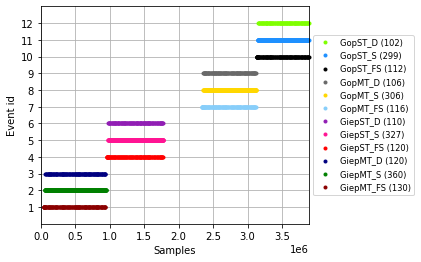

In [4]:
save_events_to_txt_file = False
if(save_events_to_txt_file):
    ifun.save_events(folder_events, eeg_dataset, eeg_filenames)
    
events = ifun.load_events(folder_events, eeg_filenames)

ifun.print_event_info(events, participant_index = 5, event_index = 500)

events_12 = epod.group_events_12(events)
fig = mne.viz.plot_events(events_12[4], event_id = epod.event_dictionary, color = disp.color_dictionary)

#### Plot of EEG signal with events

Using matplotlib as 2D backend.
Opening raw-browser...


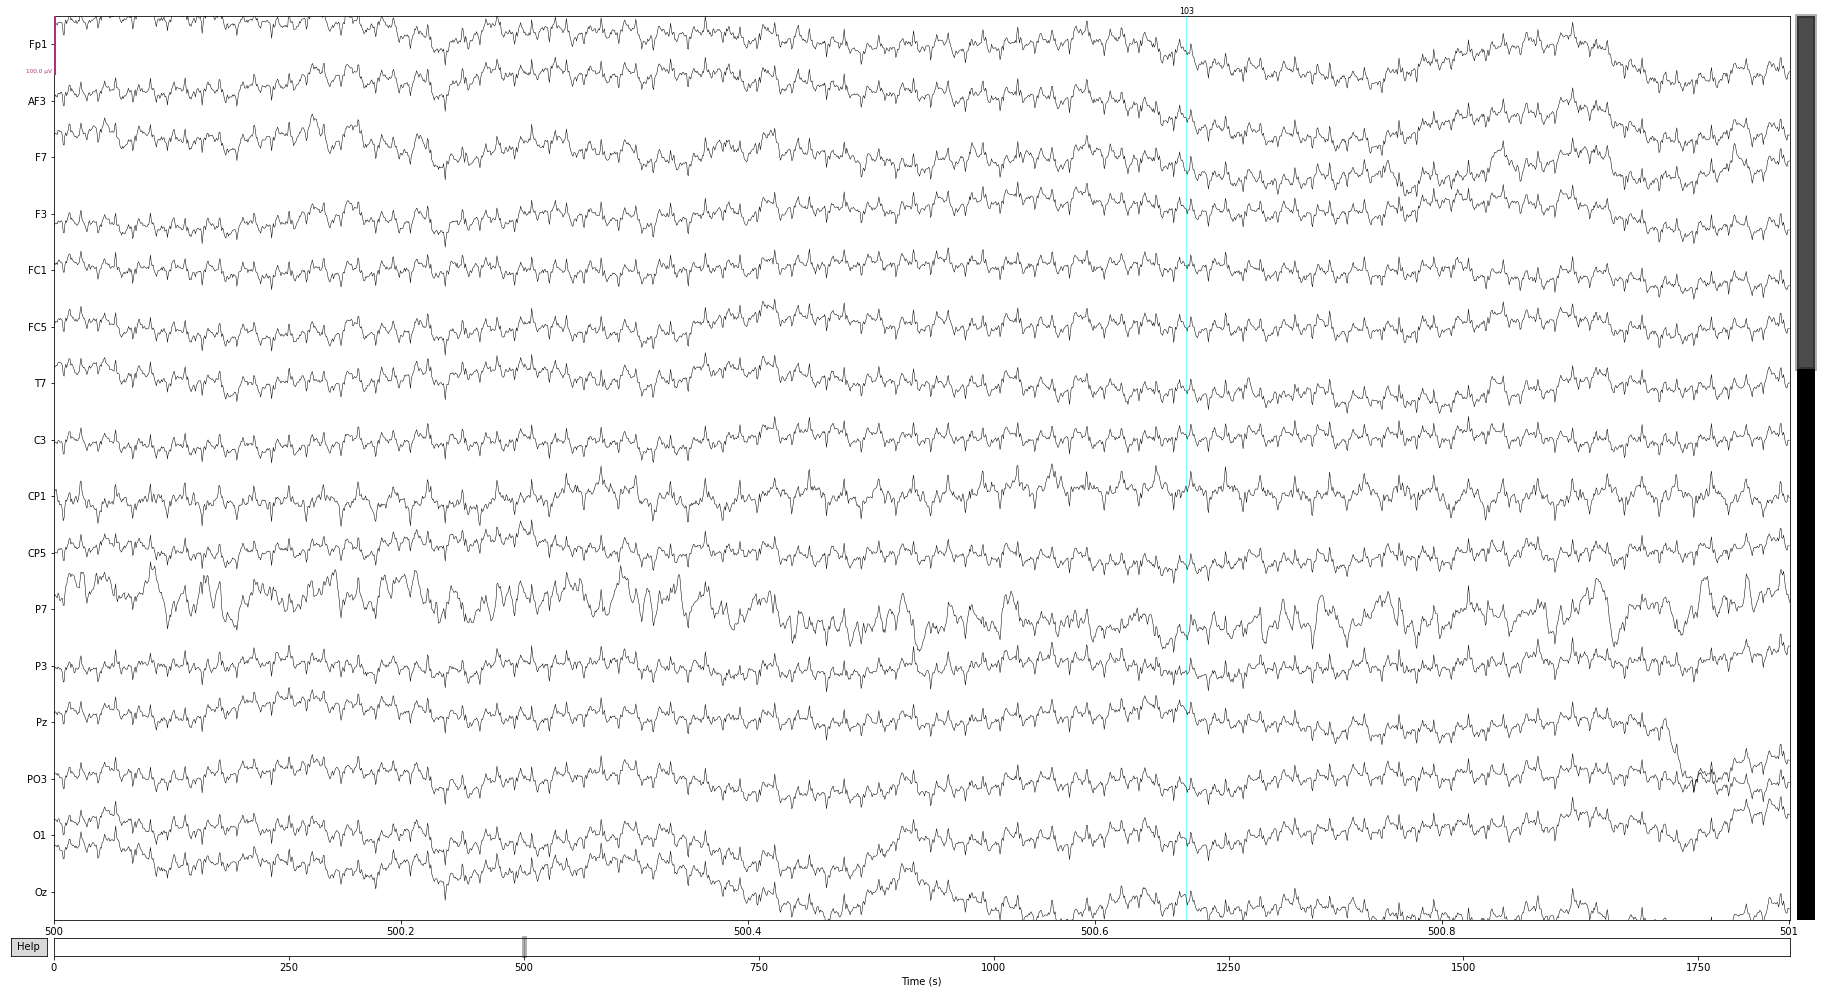

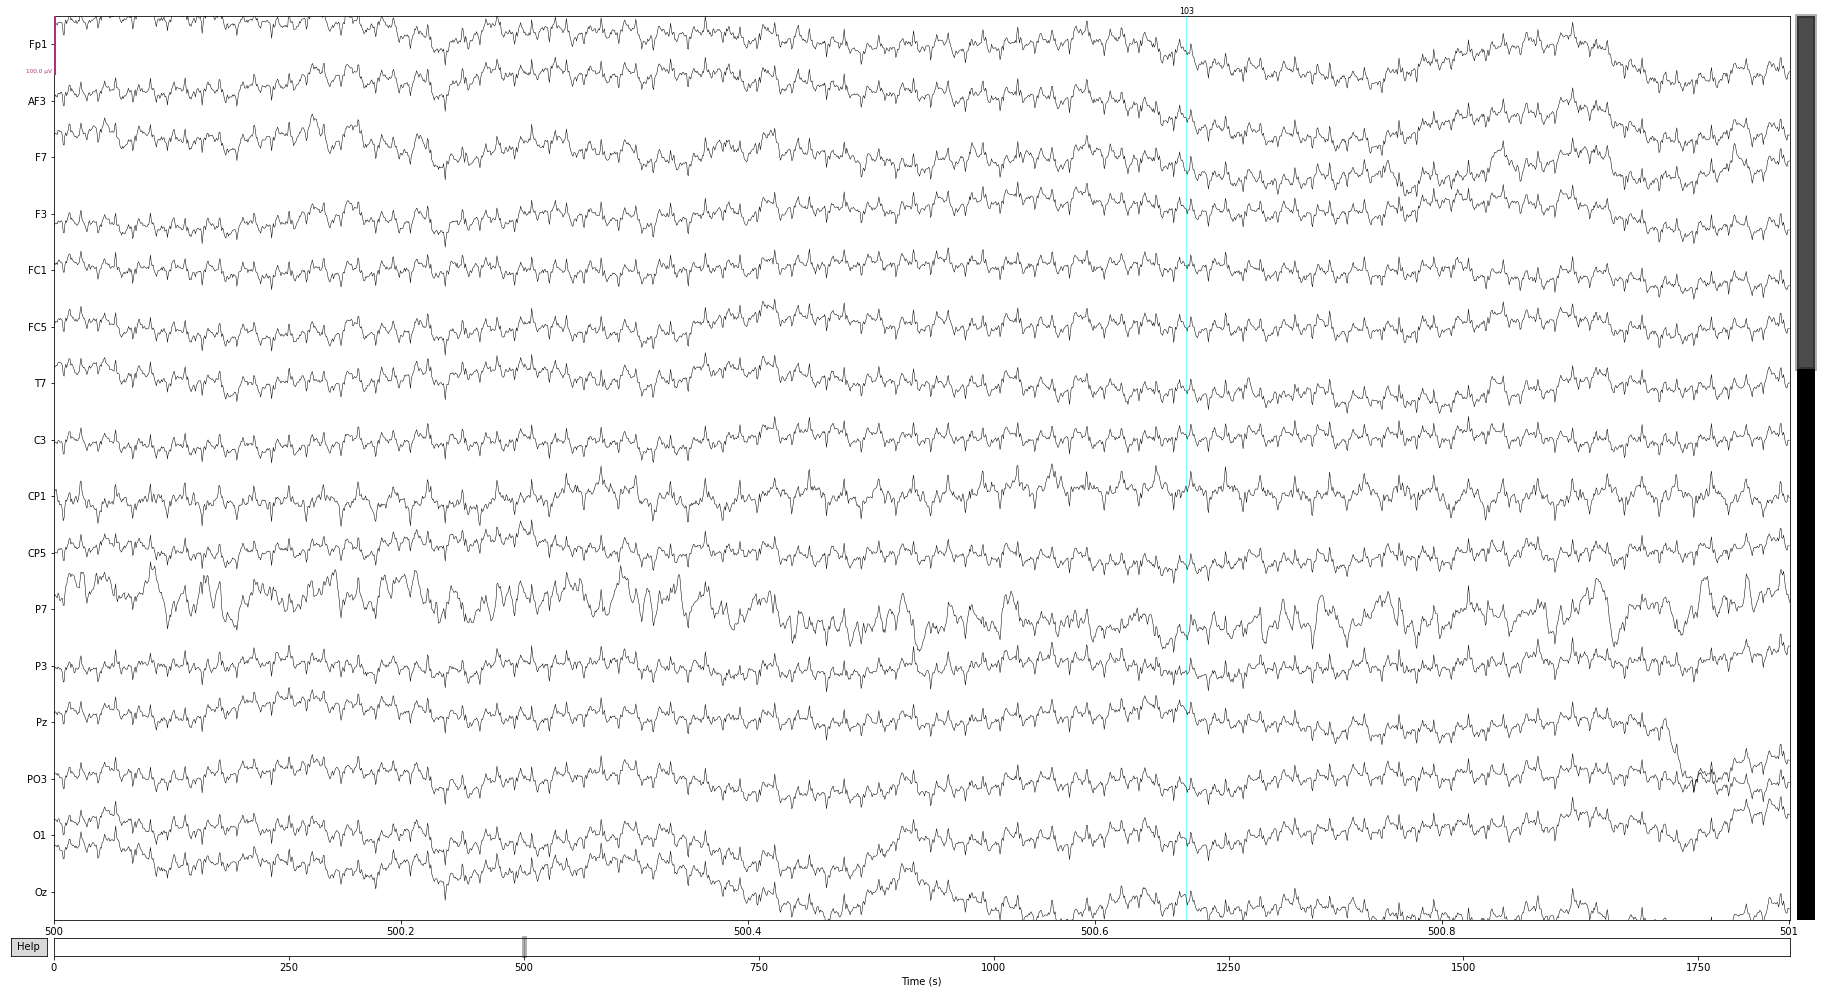

In [5]:
participant_index = 3
# %matplotlib qt / widget for interactive (remove 'fig = ' if no figure shows)
mne.viz.plot_raw(eeg_dataset[participant_index], events[participant_index], n_channels=16, scalings = 50e-6  ,duration = 1, start = 500)

#### Prepare EEG (Work in progress)
+ Subtract reference (mastoids)
+ Detrend
+ Filter
+ Remove bad channels

In [10]:
sample_rate = 2048  # Hertz
participant_index = 3
channel_index = 10
duration = 1

data, times = eeg_dataset[participant_index][:] 
## _

ValueError: too many values to unpack (expected 2)

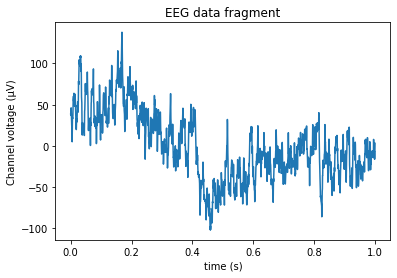

In [7]:

data_fragment = data[channel_index][200 * sample_rate : (200 + duration) * sample_rate]
data_fragment -= np.average(data_fragment)
data_fragment *= 10**6 # From micro volt to volt
time = np.arange(len(data_fragment)) / sample_rate
plt.plot(time,data_fragment)
plt.title("EEG data fragment")
plt.xlabel("time (s)")
plt.ylabel("Channel voltage (\u03BCV)")
plt.show()


#### Dummy data generator (Optional)


In [8]:
import numpy as np   
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

def generate_sine_wave(frequency, time_points):
    return np.sin((2 * np.pi) * time_points * frequency)


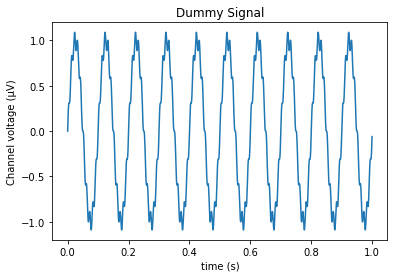

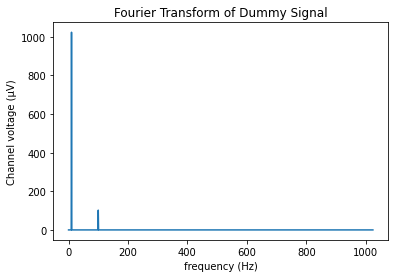

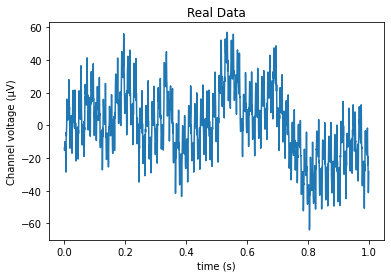

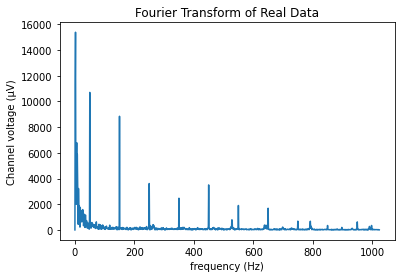

In [9]:
sample_rate = 2048  # frequency in Hertz
duration = 1  # Seconds

frequency = 10 # 1/Seconds
time_points = np.linspace(0, duration, sample_rate * duration, endpoint=False)

# Dummy Signal
signal = generate_sine_wave(10, time_points)
noise = generate_sine_wave(100, time_points)

mixed_tone = signal + noise * 0.1

plt.title("Dummy Signal")
plt.xlabel("time (s)")
plt.ylabel("Channel voltage (\u03BCV)")
plt.plot(time_points, mixed_tone)
plt.show()

# Fourier Transform of Dummy Signal
time_steps = sample_rate * duration
yf = rfft(mixed_tone)
xf = rfftfreq(time_steps, 1 / sample_rate)

plt.title("Fourier Transform of Dummy Signal")
plt.xlabel("frequency (Hz)")
plt.ylabel("Channel voltage (\u03BCV)")
plt.plot(xf, np.abs(yf))
plt.show()

# Real Data
participant_index = 3
channel_index = 20
data, _ = eeg_dataset[participant_index][:]
data_fragment = data[channel_index][200 * sample_rate : (200 + duration) * sample_rate]
data_fragment -= np.average(data_fragment)
data_fragment *= 10**6
time = np.arange(len(data_fragment)) / sample_rate

plt.title("Real Data")
plt.xlabel("time (s)")
plt.ylabel("Channel voltage (\u03BCV)")
plt.plot(time,data_fragment)
plt.show()

# Fourier Transform of Real Data
yf = rfft(data_fragment)
xf = rfftfreq(time_steps, 1 / sample_rate)

plt.title("Fourier Transform of Real Data")
plt.xlabel("frequency (Hz)")
plt.ylabel("Channel voltage (\u03BCV)")
plt.plot(xf, np.abs(yf))
plt.show()

# new_sig = rfft(data_fragment)
# print(len(new_sig))

# time = np.arange(len(data_fragment)/2+1) /sample_rate
# plt.plot(time, new_sig)
# plt.show()

#### Segment EEG into standard and deviant epochs 
+ subtract baseline
+ Reject artefacts
+ Average to get ERPs (for each subject, event, and channel separately))

#### Calculate Mismatch response 
Deviant minus (-) standard 

Check between subjects to see if the subjects have similar responses

Check between channels to observe which parts of the brain are more influenced by the events


#### Extract features 
+ peak latency
+ peak amplitude
+ mean amplitude


#### Create fitting labels


#### Input data into DL models

+ Input data X has dimensions: (subjects, trials, samples, channels)
+ Label data Y has dimensons: (subjects, trials, classes)

#### Visualise results